# Workshop CentraleSupélec - CeSIA

- Création : 02/2025 par [Nicolas Guillard](mailto:nicolas.guillar@securite-ia.fr) - bénévole au [CeSIA](https://www.securite-ia.fr/).

Créer en s'inspirant particulièrement de [Générer des noms de villes et communes françaises](https://github.com/alxndrTL/villes) par [Alexandre TL](https://www.youtube.com/@alexandretl)


## Présentation du sujet et Plan

## Indications de travail

Les éléments de ce TP :
- le présent carnet
- le répertoire `utils` et les fichiers contenus
- le fichier de données
- le répertoire weights contenant les poids des modèles

## Les modules et paramétrages globaux

Tous les modules nécessaires sont importés. A moins d'un besoin spécifique, il n'y aura pas besoin de modifier le bloc de code suivant.

In [1]:
# Modules prédéfinis et tiers
import math
import datetime
from dataclasses import dataclass
from collections import Counter
from typing import Tuple

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Modules créés pour le projet
from utils import CityNameDataset, SOS, EOS, PAD

### Device

Sélection du GPU selon l'environnement de travail

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Paramétrages

In [4]:
# Retirer la limite du nombre maximal de lignes affichées dans un tableau pandas
pd.set_option('display.max_rows', None) 

In [5]:
# Configurer le thème de seaborn
sns.set_theme(style="whitegrid")

In [ ]:
# Paramétrer les graines aléatoires
#pth_rnd_gen_device = torch.Generator(device).manual_seed(42)
if device == "cuda":
    pth_rnd_gen_device = torch.cuda.manual_seed(42)
elif device == "mps":
    pth_rnd_gen_device = torch.mps.manual_seed(42)
pth_rnd_gen_cpu = torch.manual_seed(42)

## Le modèle

Explications et schémas

### Modules prédéfinis

In [7]:
@dataclass
class TransformerConfig:
    """
    """
    vocab_size: int
    d_model: int # D or d_model in comments
    n_layers: int
    n_heads: int
    max_len: int # maximum sequence length (for positional embedding)
    dropout: float = 0.1
    bias: bool = False
    norm_eps: float = 1e-5
    super_attn: bool = False # overwrites flash to False
    flash: bool = True

    def __post_init__(self):
        assert self.d_model % self.n_heads == 0, "d_model must be a multiple of n_heads"

        self.d_head = self.d_model // self.n_heads

In [8]:
class RMSNorm(torch.nn.Module):
    """
    Root Mean Square Layer Normalization
    """
    def __init__(self, dim: int, eps: float) -> None:
        """
        Args :
            dim (int) : 
            eps (float) :
        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [9]:
class SelfAttentionMultiHead(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        Args :
            config (TransformerConfig) :
        """

        super().__init__()

        self.config = config

        # key, query, value projections for all heads
        self.query_proj = nn.Linear(config.d_model, config.d_model, bias=False) # d_query = n_heads*d_head as in the Transformer paper
        self.key_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.value_proj = nn.Linear(config.d_model, config.d_model, bias=False)

        if not config.flash:
            # compute the mask once and for all here 
            # registrer treats it like a parameter (device, state_dict...) without training
            mask = torch.full((1, 1, config.max_len, config.max_len), float('-inf'))
            mask = torch.triu(mask, diagonal=1)
            self.register_buffer('mask', mask)

        # LxL super attention params
        if config.super_attn:
            self.k_in_v_proj = nn.Linear(in_features=config.max_len, out_features=config.max_len, bias=False)

        # output projection
        self.c_proj = nn.Linear(config.d_model, config.d_model, bias=config.bias)

        # regularization
        self.attn_drop = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, S, d_model)

        B, S, _ = x.size()

        Q = self.query_proj(x).view(B, S, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, S, d_query)
        K = self.key_proj(x).view(B, S, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, S, d_key)
        V = self.value_proj(x).view(B, S, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, S, d_head=d_value)

        if self.config.flash and not self.config.super_attn:
            attention = F.scaled_dot_product_attention(
                Q, K, V, attn_mask=None, dropout_p=self.config.dropout if self.training else 0, is_causal=True
                )
        else:
            QK_T = Q @ torch.transpose(K, 2, 3) # (B, n_heads, S, S)
            QK_T = QK_T + self.mask[:, :, :S, :S]

            attention_scores = torch.softmax(QK_T / math.sqrt(self.config.d_head), dim=3) # (B, n_heads, S, S)

            if self.config.super_attn:
                attention = self.attn_drop(attention_scores) @ self.k_in_v_proj.weight @ V # (B, n_h, L, d_value=d_head)
            else:
                attention = self.attn_drop(attention_scores) @ V # (B, n_h, S, d_value=d_head)

        attention = attention.transpose(1, 2) # (B, S, n_heafs, d_head)
        y = attention.contiguous().view(B, S, self.config.d_model) # n_heads * d_head = d_model

        y = self.resid_dropout(self.c_proj(y))

        return y # (B, S, d_model)

In [10]:
class MLP(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        Args :
            config (TransformerConfig) : configuration settings
        """
        super().__init__()

        self.fc_1 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
        self.fc_2 = nn.Linear(4 * config.d_model, config.d_model, bias=config.bias)
        self.fc_3 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args :
            x (torch.Tensor) : input data  shaped (B, S, d_model)
        """
        x = self.dropout(self.fc_2(F.silu(self.fc_1(x)) * self.fc_3(x)))
        return x # (B, S, d_model)

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        Args :
            config (TransformerConfig) :
        """
        super().__init__()

        self.config = config

        self.attention_norm = RMSNorm(config.d_model, config.norm_eps)
        self.sa = SelfAttentionMultiHead(config)
        self.mlp_norm = RMSNorm(config.d_model, config.norm_eps)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
         Args :
            x (torch.Tensor) : input data shaped (B, S, d_model)
        """
        x = x + self.sa(self.attention_norm(x))
        x = x + self.mlp(self.mlp_norm(x))

        return x # (B, S, d_model)

In [12]:
class Transformer(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        """
        super().__init__()

        self.config = config

        # Positional Embedding
        self.PE = nn.Embedding(config.max_len, config.d_model) 
        self.in_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_layers)])

    def forward(self, x: torch.Tensor, stop_at_layer: int = None) -> torch.Tensor:
        """
        Args :
            x (torch.Tensor) : input data shaped (B, S, d_model)
            stop_at_layer (int) : return the ouput (activations) after the specified {layer}-th layer (1 -> n_layers)
        """
        _, S, _ = x.size()

        # Add positional embedding
        pos_emb = self.PE(torch.arange(0, S, dtype=torch.long, device=x.device))
        x = self.in_dropout(x + pos_emb)

        for i, layer in enumerate(self.layers):
            x = layer(x) # (B, S, d_model)

            if stop_at_layer == i+1:
                return x
        
        return x # (B, S, d_model)

### Définition du modèle

#### EXERCICE(S)

Il s'agit de définir la classe du modèle.
Compléter les méthodes `__init__()` et `forward()` à partir des explications 

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, model_config: TransformerConfig) -> None:
        super().__init__()

        self.config = model_config
        self.embedding = nn.Embedding(self.config.vocab_size, self.config.d_model, padding_idx=0)
        
        self.core = Transformer(self.config)
        self.out_norm = RMSNorm(self.config.d_model, self.config.norm_eps)
        self.lm_head = nn.Linear(self.config.d_model, self.config.vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight

        self.apply(self._init_weights)
        self.apply(self._init_normal)

    def _init_weights(self, module):
        # taken from llama2.c
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def _init_normal(self, module):
        for pn, p in self.named_parameters():
            if pn.endswith('fc_3.weight') or pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * self.config.n_layers))
    
    def get_logits_(self, x: torch.Tensor) -> torch.Tensor:
        x = self.out_norm(x)
        return self.lm_head(x)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        Args :
            tokens (torch.Tensor) : input shaped (B, s, vocab_size) with s in [1; S]
        """
        x = self.embedding(tokens)
        x = self.core(x)
        logits = self.get_logits_(x)

        return logits #(B, S, vocab_size)    

## Dataset et Dataloader

In [14]:
dataset = CityNameDataset(device=device)

creating vocabulary:   0%|          | 0/46 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/36585 [00:00<?, ?it/s]

## Entrainement

In [15]:
d_model = 32 # dimension du modèle
n_heads = 4 # nombre de têtes pour l'attention
n_layers = 1 # nombre de couches
dropout = 0.

lr = 3e-4
batch_size = 64

iterations = 10000
print_each = 1000

In [16]:
config = TransformerConfig(vocab_size=len(dataset.vocabulaire), d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, max_len=dataset.max_len)
model = LanguageModel(config).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)

print("> Le modèle Transformer : ", model, sep="\n")
print(f"> Nombre de paramètres : {sum(p.numel() for p in model.parameters())}")

> Le modèle Transformer : 
LanguageModel(
  (embedding): Embedding(46, 32, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(47, 32)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=32, out_features=32, bias=False)
          (key_proj): Linear(in_features=32, out_features=32, bias=False)
          (value_proj): Linear(in_features=32, out_features=32, bias=False)
          (c_proj): Linear(in_features=32, out_features=32, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=32, out_features=128, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (fc_3): Linear(in_features=32, out_features=128, bias=False)
     

In [17]:
model.train()
for i in trange(iterations):
    x, Y = dataset.get_batch(split='train', batch_size=batch_size) # (B, S)
    logits = model(x) # (B, S, vocab_size)

    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int[PAD])
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i%print_each==0:
        model.eval()
        x, Y = dataset.get_batch(batch_size=batch_size) # (B, S)
        logits = model(x) # (B, S, vocab_size)
        val_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int[PAD]).item()

        print(f"\tperte entrainement (itération #{i:5d}): {loss.item():.2f} | perte de validation : {val_loss:.2f}")
        model.train()

model.eval();

  0%|          | 0/10000 [00:00<?, ?it/s]

	perte entrainement (itération #    0): 3.82 | perte de validation : 3.81
	perte entrainement (itération # 1000): 2.22 | perte de validation : 2.24
	perte entrainement (itération # 2000): 2.13 | perte de validation : 2.18
	perte entrainement (itération # 3000): 2.01 | perte de validation : 2.00
	perte entrainement (itération # 4000): 1.99 | perte de validation : 1.89
	perte entrainement (itération # 5000): 1.88 | perte de validation : 1.92
	perte entrainement (itération # 6000): 1.87 | perte de validation : 1.91
	perte entrainement (itération # 7000): 1.77 | perte de validation : 1.83
	perte entrainement (itération # 8000): 1.93 | perte de validation : 1.83
	perte entrainement (itération # 9000): 1.82 | perte de validation : 1.81


In [18]:
x = dataset.X_train[:, :-1].to(device) # (B, S)
Y = dataset.X_train[:, 1:].long().to(device) # (B, S)
logits = model(x) # (B, S, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int['<pad>'])
print(f"total train loss : {loss.item():.2f}")

x = dataset.X_val[:, :-1].to(device) # (B, S)
Y = dataset.X_val[:, 1:].long().to(device) # (B, S)
logits = model(x) # (B, S, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int['<pad>'])
print(f"total val loss   : {loss.item():.2f}")

total train loss : 1.80
total val loss   : 1.82


Sauver les poids du modèle.

> Conseil : si vous souhaitez entrainer plusieurs fois le même modèle avec des hyperparamètres différentes, initialiser la variable `timestamp` ci-dessous à `True`. Cela provoquera l'ajout d'un marqueur temporel au format "YYYYMMDD-HHMMSS" dans le nom du fichier.

In [ ]:
timestamp = False
filename = f"./weights/model_{d_model}__{n_heads}_heads__{n_layers}_layers"
if timestamp:
    filename += "__" + datetime.datetime.now().strftime("%Y%M%d-%I%M%S")
filename += ".pth"
torch.save(model.state_dict(), filename)

## Génération de noms de commune

In [20]:
def sample(model, prompt = "", device="cpu", g = torch.Generator(device)):
    idx = torch.tensor([dataset.char_to_int[c] for c in prompt], dtype=torch.int32, device=device).unsqueeze(0)
    idx = torch.cat([torch.tensor(dataset.char_to_int[SOS], device=device).view(1, 1), idx], dim=1)
    next_id = -1

    while next_id != dataset.char_to_int[EOS]:
        logits = model(idx) # (1, len_s, d_model)

        # calcul des probas pour chaque élément du vocabulaire
        probs = F.softmax(logits[:, -1, :], dim=-1)
        # tirage au sort en prenant en compte ces probas
        next_id = torch.multinomial(probs, num_samples=1, generator=g).item()
        # concaténation
        idx = torch.cat([idx, torch.tensor(next_id, device=device).view(1, 1)], dim=1)

        if idx.shape[1] > config.max_len:
            break
        
    return "".join([dataset.int_to_char[p.item()] for p in idx[0, 1:-1]])

### EXERCICE(S)

Utiliser plusieurs fois la fonction `sample()` pour générer une vingtaine de noms de communes, en prenant différentes valeurs de `prompt`

In [ ]:
for _ in range(25):
    print(sample(model, prompt="", device=device, g=pth_rnd_gen))

barsac
dimé
plesnes
la crésy-le-colmie
courières
sacotel-e-morne
la bouvfoison
saint-fientois-et-châtom
sortaine-sur-cige
sottere-c
chazielle
saint-pret-loyan
baudrot
cureneuil
sintouveux


In [ ]:
for _ in range(25):
    print(sample(model, prompt="la", device=device, g=pth_rnd_gen))

lafradrain
la goissix
lantjoult
la veyry
la geussie
lancey
lainsac
langeix
lachalneux
lardeville
la ténie
la gesx
la beauville
la moncourt
la troy-saiux-roupicol


### EXERCICE(S)

Retrouve-t-on les distributions constatées en explorant les données ? Générez une certain nombre de noms de communes et comparer.

Les méthodes de calcul présentes dans le carnet de la première partie ont été transférées sous forme de fonctions dans la labrairie `utils` (plus exactement le fichier `utils/data_explo.py`), et sont appelées dans le code ci-dessous. Elles concernent :
- la distribution de la longueur des noms
- la fréquences des caractères dans les noms
- le taux de fréquence par rapport aux positions dans la chaîne de caractères
- la fréquence des composants de nom
- le nombre de composant de noms de communes et leur distribution

Afin de les utiliser, parcourez le fichier `utils/data_explo.py` afin de comprendre leur utilisation (c'est très facile).

In [23]:
from utils import freq_distribution, freq_char, rate_freq_by_position, freq_composition_element, composition_distribution

Générer 1000 noms de communes et constater les différents résultats statistiques obtenues avec les mêmes méthodes que dans la partie 1.

> *Conseils : création d'un Dataframe Pandas, après la génération des communes (Sur Colab avec un T4 : 2 minutes pour la génération)*

In [24]:
communes = []
N = 1000
for _ in trange(N):
    communes.append(sample(model, prompt="", device=device, g=pth_rnd_gen))

df = pd.DataFrame(communes, columns=["nom"])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
df = pd.DataFrame(communes, columns=["nom"])

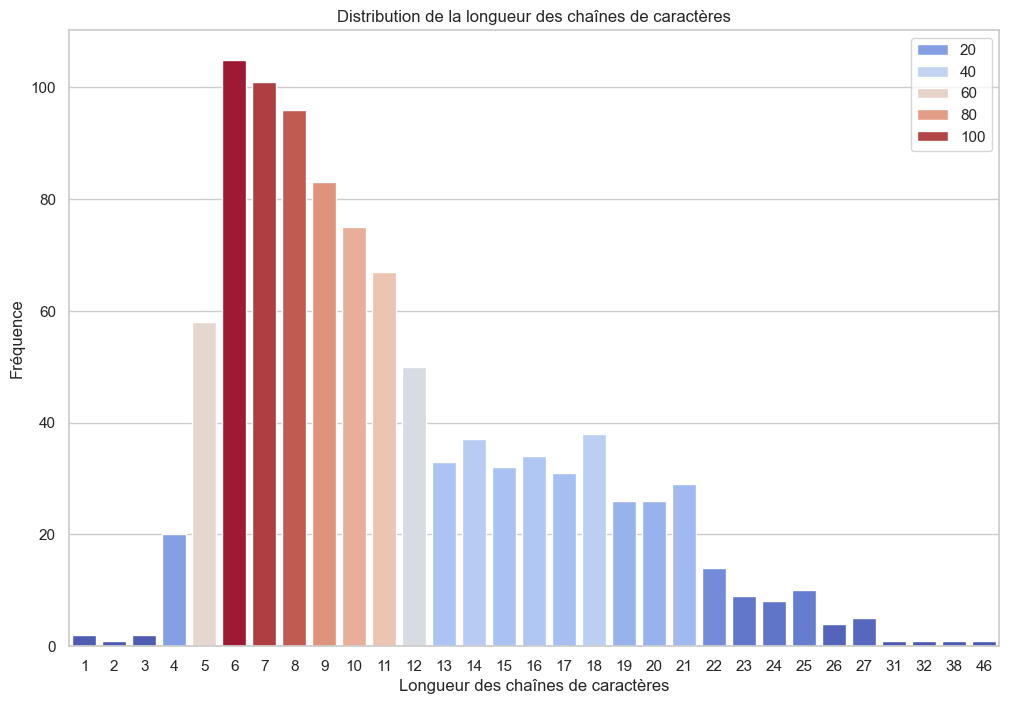

In [26]:
lengths = freq_distribution(df['nom'])

In [27]:
lengths.describe()

count    1000.000000
mean       11.467000
std         5.621789
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        46.000000
Name: nom, dtype: float64

In [28]:
freq_char(df['nom'])

Nombre de caractères distincts : 43


,Caractère,Fréquence
6,e,1217
10,a,976
7,n,865
1,i,837
8,s,834
14,l,819
2,r,786
18,-,674
19,o,632
4,t,587


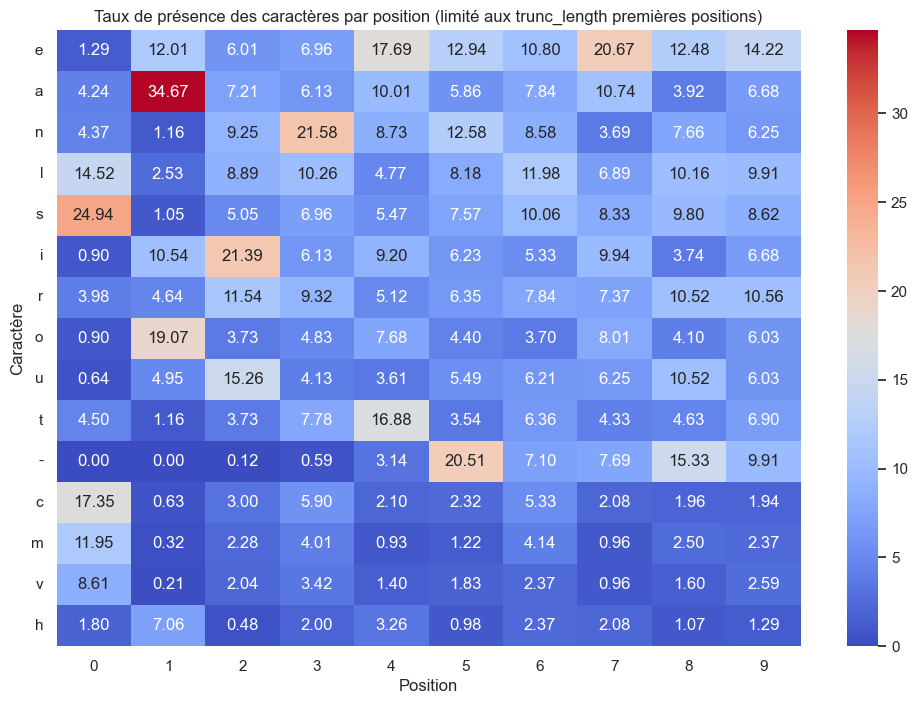

In [29]:
rate_freq_by_position(df['nom'])

In [30]:
freq_composition_element(df['nom'])

Nombre total de composants distincts : 1366


,Élément,Fréquence
169,saine,2
86,tet,1
731,beaulier,1
48,besgnas,1
196,cruéey,1
847,balsent,1
342,touvennes,1
505,blaire,1
270,lautent,1
1295,mel,1


Nombre total de composants présents plus d'une fois : 31


,Élément,Fréquence
5,saint,127
38,le,55
21,sur,51
13,la,43
90,de,25
85,en,16
91,d,12
222,l,12
130,sainte,9
413,des,7


,count
nom,
1,565
2,200
3,160
4,67
5,6
8,2


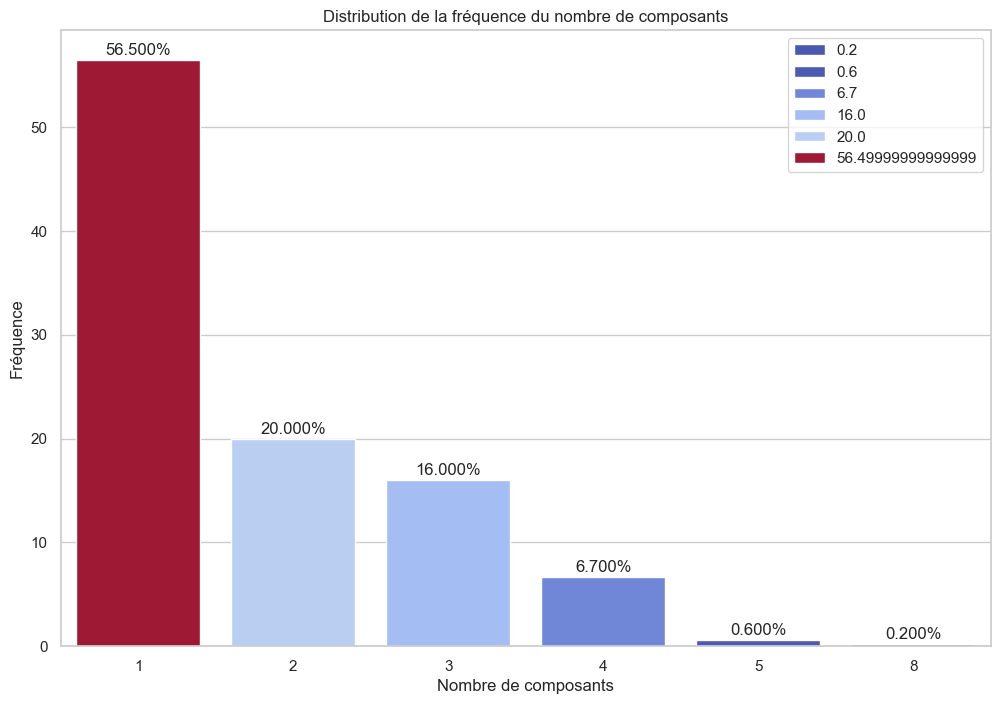

In [31]:
composition_distribution(df['nom'])

Quelles réflexions peut-on avoir au sujet de ce qu'a appris, ou n'a pas appris, le modèle ?